Returning to TimeCNN (1D CNN), we want a model that can take in a window as an input, and then successfully output the correct label. 

In [1]:
# first, open the pkl file
import pickle
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# whether we are loading all the data windows.
usingAll = True

if usingAll:
    file_path = "allwindows.pkl"
else:
    subject = 2 # the subject that we want to load
    file_path = f"windows/S{subject}windows.pkl"

with open(file_path, 'rb') as file:
    windows = pickle.load(file, encoding='latin1')

random.shuffle(windows)

In [ ]:
random.shuffle(windows)
numexamples = len(windows)

ttsplit = 0.4 

trainX = windows[: int(ttsplit * numexamples)]
testX = windows[int(ttsplit * numexamples): ]

trainY = np.zeros(len(trainX))
for i, window in enumerate(trainX):
    trainY[i] = trainX[i]['label']
    trainX[i]['label'] = None
    # print(trainY[i])

testY = np.zeros(len(testX))
for i, window in enumerate(testX):
    testY[i] = testX[i]['label']
    testX[i]['label'] = None



trainY = trainY - 1
testY = testY - 1
trainY = torch.tensor(trainY, dtype = torch.long)
testY = torch.tensor(testY, dtype = torch.long)


print(trainY)
print(len(testX))
print(len(testY))

tensor([0, 2, 0,  ..., 1, 1, 1])
1992
1992


In [3]:
print(len(windows)) # 1105 windows in total.
print(len(trainX)) # 1105 windows in total.

example = windows[1000]
print(example["signal"]["wrist"]["ACC"])
print(len(example["signal"]["wrist"]["TEMP"]))

# lengths of each signal:


# chestACC: 600
# chestECG: 4200 
# chestEDA: 210
# chestEMG: 600
# cheestResp: 210
# chestTemp: 210


# wristACC: 480
# wristBVP: 3840
# wristEDA: 240
# wristTEMP: 240


3320
1328
[[0.26612903 0.46774194 0.07258065]
 [0.26612903 0.46774194 0.07258065]
 [0.26612903 0.46774194 0.07258065]
 [0.26612903 0.46774194 0.07258065]
 [0.26612903 0.46774194 0.07258065]
 [0.27419355 0.46774194 0.07258065]
 [0.27419355 0.46774194 0.07258065]
 [0.26612903 0.46774194 0.07258065]
 [0.26612903 0.46774194 0.07258065]
 [0.26612903 0.46774194 0.07258065]
 [0.26612903 0.46774194 0.07258065]
 [0.27419355 0.46774194 0.07258065]
 [0.26612903 0.46774194 0.07258065]
 [0.26612903 0.46774194 0.07258065]
 [0.26612903 0.46774194 0.07258065]
 [0.26612903 0.46774194 0.07258065]
 [0.26612903 0.46774194 0.07258065]
 [0.26612903 0.46774194 0.07258065]
 [0.27419355 0.46774194 0.07258065]
 [0.27419355 0.46774194 0.07258065]
 [0.26612903 0.46774194 0.07258065]
 [0.26612903 0.46774194 0.07258065]
 [0.27419355 0.47580645 0.07258065]
 [0.27419355 0.46774194 0.07258065]
 [0.27419355 0.46774194 0.07258065]
 [0.27419355 0.46774194 0.07258065]
 [0.26612903 0.46774194 0.07258065]
 [0.26612903 0.467

For the first attempt, I may choose to omit ACC (acceleration). I'm not entirely convinced that accelerometers and acceleration are biosignals, and their 3 signal format makes them slightly more tricky to work with than the other signals. It seems to be fair game to include them, especially with such little data available, but I will attempt to train a model without them first.

In [4]:


class MultiSignalTimeCNNnoACC(nn.Module):
    def __init__(self, input_dim_1, input_dim_2, input_dim_3, input_dim_4, input_dim_5, input_dim_6, input_dim_7, input_dim_8, num_classes=3):
        super(MultiSignalTimeCNNnoACC, self).__init__()

        # CNN Branch for Signal 1
        self.cnn1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=6, kernel_size=7, padding=3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=3),
            nn.Conv1d(in_channels=6, out_channels=12, kernel_size=7, padding=3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=3),
            nn.Flatten()
        )

        # CNN Branch for Signal 2
        self.cnn2 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=6, kernel_size=7, padding=3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=3),
            nn.Conv1d(in_channels=6, out_channels=12, kernel_size=7, padding=3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=3),
            nn.Flatten()
        )

        # CNN Branch for Signal 3
        self.cnn3 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=6, kernel_size=7, padding=3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=3),
            nn.Conv1d(in_channels=6, out_channels=12, kernel_size=7, padding = 3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=3),
            nn.Flatten()
        )
        self.cnn4 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=6, kernel_size=7, padding=3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=3),
            nn.Conv1d(in_channels=6, out_channels=12, kernel_size=7, padding = 3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=3),
            nn.Flatten()
        )
        self.cnn5 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=6, kernel_size=7, padding=3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=3),
            nn.Conv1d(in_channels=6, out_channels=12, kernel_size=7, padding = 3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=3),
            nn.Flatten()
        )
        self.cnn6 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=6, kernel_size=7, padding=3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=3),
            nn.Conv1d(in_channels=6, out_channels=12, kernel_size=7, padding = 3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=3),
            nn.Flatten()
        )
        self.cnn7 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=6, kernel_size=7, padding=3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=3),
            nn.Conv1d(in_channels=6, out_channels=12, kernel_size=7, padding=3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=3),
            nn.Flatten()
        )
        self.cnn8 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=6, kernel_size=7, padding=3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=3),
            nn.Conv1d(in_channels=6, out_channels=12, kernel_size=7, padding=3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=3),
            nn.Flatten()
        )

        # Calculate the size of the flattened CNN output
        flattened_size_1 = 12 * (((input_dim_1) // 3) // 3)
        flattened_size_2 = 12 * (((input_dim_2) // 3) // 3)
        flattened_size_3 = 12 * (((input_dim_3) // 3) // 3)
        flattened_size_4 = 12 * (((input_dim_4) // 3) // 3)
        flattened_size_5 = 12 * (((input_dim_5) // 3) // 3)
        flattened_size_6 = 12 * (((input_dim_6) // 3) // 3)
        flattened_size_7 = 12 * (((input_dim_7) // 3) // 3)
        flattened_size_8 = 12 * (((input_dim_8) // 3) // 3)
        

        # Total size after concatenating the flattened outputs
        total_flattened_size = flattened_size_1 + flattened_size_2 + flattened_size_3 + flattened_size_4 + flattened_size_5 + flattened_size_6 + flattened_size_7 + flattened_size_8

        # Fully connected layers
        self.fc1 = nn.Linear(total_flattened_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, datawindow):
        signal = []
        for device in datawindow["signal"]:
            for s in datawindow["signal"][device]:
                if (s != "ACC"): # excluding ACC for now.
                    signal.append(np.zeros((len(datawindow["signal"][device][s]))))
                    for i in range(len(datawindow["signal"][device][s])):
                        signal[-1][i] = datawindow["signal"][device][s][i]
                    signal[-1] = torch.from_numpy(signal[-1]).float().unsqueeze(0).unsqueeze(0)
                        
        # print(signal)



        # Pass each signal through its respective CNN branch
        x1 = self.cnn1(signal[0])
        x2 = self.cnn2(signal[1])
        x3 = self.cnn3(signal[2])
        x4 = self.cnn4(signal[3])
        x5 = self.cnn1(signal[4])
        x6 = self.cnn2(signal[5])
        x7 = self.cnn3(signal[6])
        x8 = self.cnn4(signal[7])

        # Concatenate the features from each branch
        combined = torch.cat((x1, x2, x3, x4, x5, x6, x7, x8), dim=1)

        # Pass through fully connected layers
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.softmax(x, dim=1)

        return x



Below is the training loop:
Note the default input_dim sizes for 60s windows (double click cell to copy):

input_dim_1 = 4200
input_dim_2 = 210
input_dim_3 = 600
input_dim_4 = 210
input_dim_5 = 210
input_dim_6 = 3840
input_dim_7 = 240
input_dim_8 = 240


In [5]:
input_dim_1 = 700
input_dim_2 = 35
input_dim_3 = 100
input_dim_4 = 35
input_dim_5 = 35
input_dim_6 = 640
input_dim_7 = 40
input_dim_8 = 40
num_classes = 3

model = MultiSignalTimeCNNnoACC(input_dim_1=input_dim_1, input_dim_2=input_dim_2, input_dim_3=input_dim_3, input_dim_4=input_dim_4, input_dim_5=input_dim_5, input_dim_6=input_dim_6, input_dim_7=input_dim_7, input_dim_8=input_dim_8, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 1 # probably will break if you change this as of rn.
num_epochs = 10

train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Shuffle data at the beginning of each epoch (optional but recommended)
    indices = torch.randperm(len(trainY))

    correct = 0
    total = 0

    for i in range(0, len(trainY), batch_size):
        batch_indices = indices[i:i + batch_size]
        
        # Extract batch data
        batch_data = trainX[batch_indices]
        batch_labels = trainY[batch_indices]

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_data)
        
        # Compute loss
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(batch_labels)

        _, predicted = torch.max(outputs, 1)
        total += batch_size
        correct += (predicted == batch_labels).sum().item()

    epoch_loss = running_loss / len(trainY)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")
    train_accuracies.append(100 * correct / total)
    model.eval()


    with torch.no_grad():
        correct = 0
        total = 0
        for i in range(0, len(testY), batch_size):
            batch_indices = i
            batch_data = testX[batch_indices]
            batch_labels = testY[batch_indices]
            
            outputs = model(batch_data)


            _, predicted = torch.max(outputs, 1)
            total += batch_size
            correct += (predicted == batch_labels).sum().item()

        print(f"Test Accuracy: {100 * correct / total:.2f}%")
        test_accuracies.append(100 * correct / total)

/var/folders/2v/tx1mp_vs3_z5try3g36zl0g40000gn/T/ipykernel_2661/3200648468.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  signal[-1][i] = datawindow["signal"][device][s][i]


Epoch 1/10, Loss: 1.0266, Accuracy: 51.73%
Test Accuracy: 53.66%
Epoch 2/10, Loss: 0.8057, Accuracy: 74.47%
Test Accuracy: 79.17%
Epoch 3/10, Loss: 0.7320, Accuracy: 81.17%
Test Accuracy: 84.59%
Epoch 4/10, Loss: 0.6951, Accuracy: 85.62%
Test Accuracy: 86.70%
Epoch 5/10, Loss: 0.6752, Accuracy: 87.80%
Test Accuracy: 87.45%
Epoch 6/10, Loss: 0.6727, Accuracy: 87.65%
Test Accuracy: 86.90%
Epoch 7/10, Loss: 0.6651, Accuracy: 88.48%
Test Accuracy: 87.35%
Epoch 8/10, Loss: 0.6690, Accuracy: 88.40%
Test Accuracy: 86.60%
Epoch 9/10, Loss: 0.6644, Accuracy: 88.70%
Test Accuracy: 86.75%
Epoch 10/10, Loss: 0.6612, Accuracy: 89.08%
Test Accuracy: 87.95%


Matplotlib is building the font cache; this may take a moment.


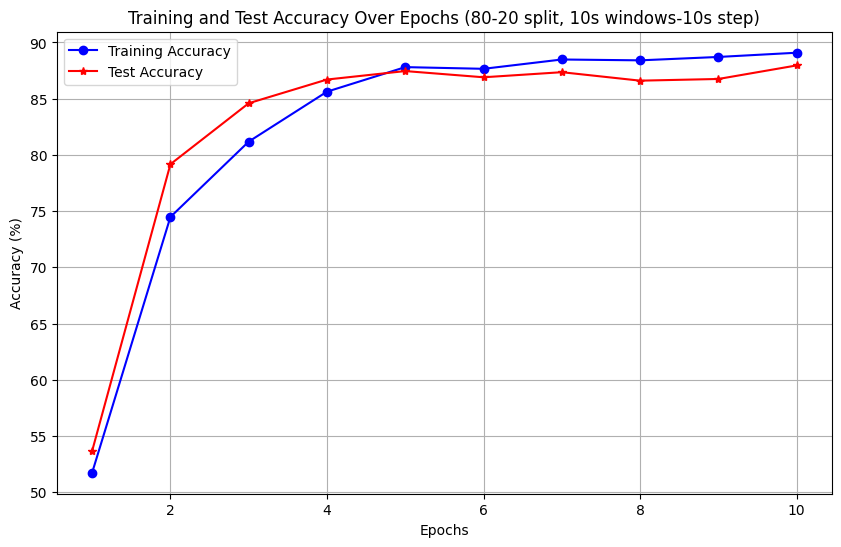

In [7]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'r*-', label='Test Accuracy')
plt.title('Training and Test Accuracy Over Epochs (80-20 split, 10s windows-10s step)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i in range(0, len(testY), batch_size):
        batch_indices = i
        batch_data = testX[batch_indices]
        batch_labels = testY[batch_indices]
        
        outputs = model(batch_data)


        _, predicted = torch.max(outputs, 1)
        total += batch_size
        correct += (predicted == batch_labels).sum().item()
        print(outputs)
        print(batch_labels)

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

print(model(testX[300]))
print(testY[300])

/var/folders/2v/tx1mp_vs3_z5try3g36zl0g40000gn/T/ipykernel_2661/3200648468.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  signal[-1][i] = datawindow["signal"][device][s][i]


tensor([[7.9293e-05, 9.9919e-01, 7.3505e-04]])
tensor(1)
tensor([[9.3360e-05, 3.0917e-03, 9.9681e-01]])
tensor(1)
tensor([[5.1783e-05, 9.9969e-01, 2.6176e-04]])
tensor(1)
tensor([[1.0000e+00, 2.6048e-08, 1.0619e-07]])
tensor(0)
tensor([[1.0000e+00, 5.7528e-08, 6.1180e-07]])
tensor(0)
tensor([[0.0304, 0.0172, 0.9525]])
tensor(2)
tensor([[4.6047e-06, 9.9963e-01, 3.6560e-04]])
tensor(1)
tensor([[9.9993e-01, 2.9325e-06, 7.0254e-05]])
tensor(0)
tensor([[1.8611e-05, 1.4653e-05, 9.9997e-01]])
tensor(2)
tensor([[1.0000e+00, 1.9482e-15, 3.0425e-15]])
tensor(0)
tensor([[0.9696, 0.0020, 0.0284]])
tensor(0)
tensor([[4.4885e-07, 9.9999e-01, 1.1263e-05]])
tensor(1)
tensor([[9.8224e-07, 9.9993e-01, 6.5375e-05]])
tensor(1)
tensor([[1.0000e+00, 1.0690e-18, 2.4946e-17]])
tensor(0)
tensor([[1.0000e+00, 1.0964e-13, 6.8846e-14]])
tensor(0)
tensor([[1.0000e+00, 1.1824e-09, 1.9228e-09]])
tensor(0)
tensor([[1.0000e+00, 8.8080e-15, 2.0689e-15]])
tensor(0)
tensor([[1.0727e-04, 4.9027e-06, 9.9989e-01]])
tensor(2